# 01 Cross-sectional Analysis

## Description

This notebook contains some preliminary analysis of stock market data through forecast error network analysis.

## TO DO
- #

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
import sys
sys.path.append('../')
sys.path.append('../../kungfu/')
import kungfu as kf

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [22]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

## Load data

In [5]:
return_matrix = pd.read_csv('../data/processed/return_matrix.csv').set_index('date')
return_matrix.index = pd.to_datetime(return_matrix.index, yearfirst=True)
return_matrix.columns.name = 'permno'

In [6]:
#pd.read_hdf('../data/processed/return_matrix_2019.hdf')

In [7]:
df_ff_raw = pd.read_pickle('../data/external/df_ff_raw.pkl')

In [8]:
df_factor_models = return_matrix[return_matrix.index.year==2019]\
                        .merge(df_ff_raw[df_ff_raw.index.year==2019], how='left', left_index=True, right_index=True)

In [9]:
df_regressions = pd.read_csv('../data/processed/descriptive.csv').set_index('permno')

df_regressions[['comnam','ticker']] = df_regressions[['comnam','ticker']].astype('str')
df_regressions[['exchcd','min_rank']] = df_regressions[['exchcd','min_rank']].astype('int')

## Estimate CAPM betas

In [10]:
x = df_factor_models['mktrf']
for permno in return_matrix.columns:
    y = df_factor_models[permno]# - df_factor_models['rf']
    capm_reg = sm.OLS(y, sm.add_constant(x)).fit()
    df_regressions.at[int(permno),'capm_beta'] = capm_reg.params[1]
    df_regressions.at[int(permno),'r_squared'] = capm_reg.rsquared
    
    df_regressions.at[int(permno),'excess_return_2019'] = y.mean()*252
    df_regressions.at[int(permno),'variance_2019'] = y.var()*252
    
    df_regressions.at[int(permno),'excess_return_2018-19'] = return_matrix.loc[return_matrix.index.year>=2018,permno].mean()*252
    df_regressions.at[int(permno),'variance_2018-19'] = return_matrix.loc[return_matrix.index.year>=2018,permno].var()*252
    
    df_regressions.at[int(permno),'excess_return_full'] = return_matrix[permno].mean()*252
    df_regressions.at[int(permno),'variance_full'] = return_matrix[permno].var()*252
    
    df_regressions.at[int(permno),'excess_return_until_2018'] = return_matrix.loc[return_matrix.index.year<2019,permno].mean()*252
    df_regressions.at[int(permno),'variance_until_2018'] = return_matrix.loc[return_matrix.index.year<2019,permno].var()*252
    
#df_regressions.to_csv('../data/processed/df_regressions.csv')

In [11]:
df_regressions.head()

,comnam,ticker,exchcd,min_rank,capm_beta,r_squared,excess_return_2019,variance_2019,excess_return_2018-19,variance_2018-19,excess_return_full,variance_full,excess_return_until_2018,variance_until_2018
permno,,,,,,,,,,,,,,
10104,ORACLE CORP,ORCL,1,11,1.015724,0.447464,0.174896,0.039292,0.080028,0.052007,0.097128,0.149900,0.093027,0.155740
10107,MICROSOFT CORP,MSFT,3,1,1.218316,0.643494,0.453322,0.039309,0.332757,0.059497,0.100874,0.090716,0.082290,0.093409
10138,T ROWE PRICE GROUP INC,TROW,3,171,1.315447,0.569249,0.309246,0.051803,0.110989,0.058505,0.167189,0.132109,0.159698,0.136351
10145,HONEYWELL INTERNATIONAL INC,HON,1,50,1.012552,0.583009,0.306519,0.029969,0.110015,0.033702,0.111523,0.092681,0.101241,0.095987
10516,ARCHER DANIELS MIDLAND CO,ADM,1,103,0.844864,0.299900,0.156632,0.040561,0.104066,0.037930,0.123740,0.093485,0.122006,0.096285


## Join with FEVD results

In [12]:
df_regressions['incoming_2019_v1'] = pd.read_csv('../data/external/IN_2019_v1.csv', header=None).values
df_regressions['outgoing_2019_v1'] = pd.read_csv('../data/external/OUT_2019_v1.csv').T.index.to_list()

df_regressions['incoming_2019_v2'] = pd.read_csv('../data/external/IN_2019_v2.csv', header=None).values
df_regressions['outgoing_2019_v2'] = pd.read_csv('../data/external/OUT_2019_v2.csv').T.index.to_list()

df_regressions['incoming_2018-19'] = pd.read_csv('../data/external/IN_2018-19.csv', header=None).values
df_regressions['outgoing_2018-19'] = pd.read_csv('../data/external/OUT_2018-19.csv').T.index.to_list()

df_regressions['incoming_vola_2019'] = pd.read_csv('../data/external/IN_vola_2019.csv', header=None).values
df_regressions['outgoing_vola_2019'] = pd.read_csv('../data/external/OUT_vola_2019.csv').T.index.to_list()

outgoing = ['outgoing_2019_v1',
            'outgoing_2019_v2',
            'outgoing_2018-19',
            'outgoing_vola_2019']
df_regressions[outgoing] = df_regressions[outgoing].astype('float')
df_regressions.dtypes

comnam                       object
ticker                       object
exchcd                        int32
min_rank                      int32
capm_beta                   float64
r_squared                   float64
excess_return_2019          float64
variance_2019               float64
excess_return_2018-19       float64
variance_2018-19            float64
excess_return_full          float64
variance_full               float64
excess_return_until_2018    float64
variance_until_2018         float64
incoming_2019_v1            float64
outgoing_2019_v1            float64
incoming_2019_v2            float64
outgoing_2019_v2            float64
incoming_2018-19            float64
outgoing_2018-19            float64
incoming_vola_2019          float64
outgoing_vola_2019          float64
dtype: object

## Regression Laboratory

In [13]:
df_regressions['ext_variance_2019'] =  np.sqrt(df_regressions['variance_2019'] * df_regressions['incoming_2019_v2'])


In [14]:
y = df_regressions['excess_return_until_2018']
x = df_regressions[['incoming_2019_v2','capm_beta']]
x = df_regressions[['ext_variance_2019','capm_beta']]
#x = df_regressions[['capm_beta']]

sm.OLS(y, sm.add_constant(x)).fit().summary()

#regression_formula = 'mean_excess_return_full ~ vola_2019 * outgoing_2019_v1 + vola_2019 * incoming_2019_v1'
#smf.ols(formula=regression_formula, data=df_regressions).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     excess_return_until_2018   R-squared:                       0.061
Model:                                  OLS   Adj. R-squared:                  0.052
Method:                       Least Squares   F-statistic:                     7.152
Date:                      Fri, 15 May 2020   Prob (F-statistic):           0.000978
Time:                              10:33:45   Log-Likelihood:                 299.49
No. Observations:                       224   AIC:                            -593.0
Df Residuals:                           221   BIC:                            -582.7
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1067      0.011      9.776      0.000       0.085       0.128
ext_variance_2019    -0.1716      0.059     -2.907      0.004      -0.288      -0.055
capm_beta             0.0574      0.015      3.782      0.000       0.027       0.087
==============================================================================
Omnibus:                       34.594   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.678
Skew:                           0.723   Prob(JB):                     1.36e-17
Kurtosis:                       5.496   Cond. No.                         20.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

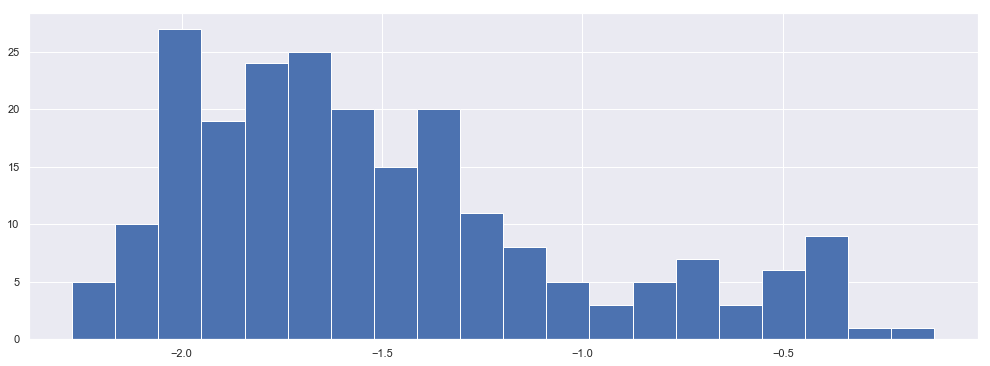

In [15]:
(np.log(1-df_regressions['incoming_2019_v2'])).hist(bins=20)

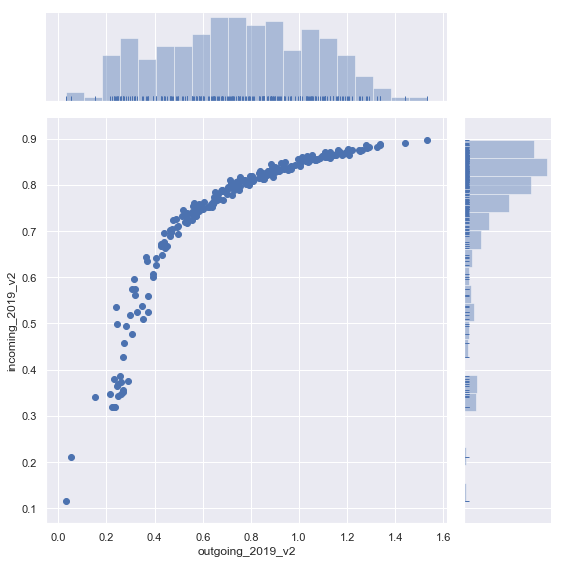

In [47]:
joint = sns.jointplot(df_regressions['outgoing_2019_v2'], (df_regressions['incoming_2019_v2']), height=8, ratio=4, marginal_kws=dict(bins=20, rug=True))
#joint.fig.set_figwidth(17)

## Annual Regressions

In [17]:
df_regressions = kf.FinancialDataFrame(df_regressions)
df_regressions.head()

,comnam,ticker,exchcd,min_rank,capm_beta,r_squared,excess_return_2019,variance_2019,excess_return_2018-19,variance_2018-19,...,variance_until_2018,incoming_2019_v1,outgoing_2019_v1,incoming_2019_v2,outgoing_2019_v2,incoming_2018-19,outgoing_2018-19,incoming_vola_2019,outgoing_vola_2019,ext_variance_2019
permno,,,,,,,,,,,,,,,,,,,,,
10104,ORACLE CORP,ORCL,1,11,1.015724,0.447464,0.174896,0.039292,0.080028,0.052007,...,0.155740,0.964147,1.356163,0.811842,0.813514,0.812095,0.814515,0.576128,0.826344,0.178603
10107,MICROSOFT CORP,MSFT,3,1,1.218316,0.643494,0.453322,0.039309,0.332757,0.059497,...,0.093409,0.961006,1.365082,0.865818,1.208431,0.866017,1.210446,0.735891,1.342655,0.184483
10138,T ROWE PRICE GROUP INC,TROW,3,171,1.315447,0.569249,0.309246,0.051803,0.110989,0.058505,...,0.136351,0.967885,1.400100,0.873188,1.254276,0.873369,1.255823,0.668998,0.957616,0.212683
10145,HONEYWELL INTERNATIONAL INC,HON,1,50,1.012552,0.583009,0.306519,0.029969,0.110015,0.033702,...,0.095987,0.971957,1.766730,0.824992,0.882798,0.825250,0.883891,0.609685,0.829284,0.157239
10516,ARCHER DANIELS MIDLAND CO,ADM,1,103,0.844864,0.299900,0.156632,0.040561,0.104066,0.037930,...,0.096285,0.941007,0.772855,0.753445,0.592429,0.753771,0.593206,0.470563,0.482374,0.174816


In [18]:
table_regressions = kf.RegressionTable()
endog = 'excess_return_full'
exogs = ['incoming_2019_v1',
         'outgoing_2019_v1',
         'capm_beta',
         ['incoming_2019_v1','capm_beta'],
         ['outgoing_2019_v1','capm_beta'],
         ['ext_variance_2019','capm_beta'],
        ]

add_outputs = ['R-squared', 'N']

for exog in exogs:
    table_regressions = table_regressions.join_regression(df_regressions.fit_linear_regression(endog=endog, exog=exog, lag=0), add_outputs=add_outputs)
table_regressions

(1)        (2)        (3)       (4)  \
capm_beta         coeff                          0.0227**    0.0137   
                  t-stat                         (2.3527)  (1.2889)   
const             coeff      0.0416  0.1244***  0.1082***    0.0471   
                  t-stat   (1.3019)  (13.0816)  (10.2940)  (1.4638)   
ext_variance_2019 coeff                                               
                  t-stat                                              
incoming_2019_v1  coeff   0.0989***                        0.0777**   
                  t-stat   (2.8218)                        (2.0091)   
outgoing_2019_v1  coeff                 0.0072                        
                  t-stat              (0.7642)                        
N                               224        224        224       224   
R-squared                    0.0346     0.0026     0.0243    0.0418   

                                (5)         (6)  
capm_beta         coeff    0.0229**   0.0579***  
                  t-stat   (2.2177)    (3.9644)  
const             coeff   0.1084***   0.1146***  
                  t-stat   (9.1492)   (10.9117)  
ext_variance_2019 coeff              -0.1797***  
                  t-stat              (-3.1637)  
incoming_2019_v1  coeff                          
                  t-stat                         
outgoing_2019_v1  coeff     -0.0004              
                  t-stat  (-0.0433)              
N                               224         224  
R-squared                    0.0243      0.0666